# Test equivital measurements
Plot and review measurements from equivital sensors as output by the Equivital Manager app.
(Every program produces different formated files and it's a pain.)

In [52]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import heartpy as hp

from scipy.signal import butter,filtfilt
from scipy import interpolate
from scipy.interpolate import interp1d

## Definitions for data extraction

In [195]:
def eq_file_dets(eq_file_loc): # files output by kiosk have followed this filename formating
    file_name = eq_file_loc.split('/')[-1]
    a = file_name.split('.')[0].split('_') #eq_file_dets(f)
    File_dets={'Signal':a[1] ,
           'Participant':'NA', 
           'DevID':'NA' , 
           'Date':int(a[0][:6]) ,
           'Session':int(a[0][6:]),
           'FileName':file_name,
           'FullLoc':f}
    return File_dets

def min_dets(eq_file_loc): # for files output by the lab manager desktop app, so far
    filings = eq_file_loc.split('/')
    file_name = filings[-1]
    f = file_name.split('.')
    if len(file_name.split(' '))==2:
        fileDate = file_name.split(' ')[0]
        Session = 'NA'
    else:
        fileDate = file_name.split('_')[0][:6]
        Session = file_name.split('_')[0][7:]
        
    File_dets={'Signal':f[-2][9:], #f[-2].split('_')[-1],
       'ID':filings[-2], 
       'Date':fileDate ,
       'Session':Session,
       'FileName':file_name,
       'FileType':f[-1],
       'FullLoc':eq_file_loc}
    return File_dets

In [199]:
# should convert for types and not change names of columns? .astype(float)

def eq_file_exct(eq_file_loc): # Files output by labManager
    dets=min_dets(eq_file_loc)
    #print(dets)
    V = pd.read_csv(eq_file_loc,skipinitialspace=True)
    # Extract according to signal type
    if dets['Signal'] == 'RR':
    #'Date (M/d/yyyy)', 'Time (HH:mm:ss.000)', 'Inter Beat Interval (ms)'
        V.loc[:,'Time'] = pd.to_datetime(V.loc[:,'Date (M/d/yyyy)']+ V.loc[:,'Time (HH:mm:ss.000)']) 
        sig_df = pd.DataFrame(index = V.loc[:,'Time'],
                     columns = ['IBI_ms'],
                     data = V.loc[:,'Inter Beat Interval (ms)'].values)
        return sig_df
    if dets['Signal'] == 'ECGmV':
    # Index(['Date (M/d/yyyy)', 'Time (HH:mm:ss.000)', 'ECG Lead 1', 'ECG Lead 2']
        V.loc[:,'Time'] = pd.to_datetime(V.loc[:,'Date (M/d/yyyy)']+ V.loc[:,'Time (HH:mm:ss.000)']) 
        sig_df = V.loc[:,['ECG Lead 1', 'ECG Lead 2']].copy()
        sig_df.set_index(pd.to_datetime(V.loc[:,'Time']),inplace=True)
        return sig_df
    if dets['Signal'] == 'Belt':
    # 'Date (M/d/yyyy)', 'Time (HH:mm:ss.000)', 'Breathing Wave'
        V.loc[:,'Time'] = pd.to_datetime(V.loc[:,'Date (M/d/yyyy)']+ V.loc[:,'Time (HH:mm:ss.000)']) 
        V.loc[:,'Breathing'] = V.loc[:,'Breathing Wave'].astype('int64')
        sig_df = V.loc[:,['Breathing']].copy()
        sig_df.set_index(V.loc[:,'Time'],inplace=True)
        return sig_df 
    if dets['Signal'].lower().startswith('acc'): # AccMG and AccmG_HR 
        V.loc[:,'Time'] = pd.to_datetime(V.loc[:,'Date (M/d/yyyy)']+ V.loc[:,'Time (HH:mm:ss.000)']) 
        V.loc[:,'Z'] = V.loc[:,'Vertical Acc']
        V.loc[:,'Y'] = V.loc[:,'Lateral Acc']
        V.loc[:,'X'] = V.loc[:,'Longitudinal Acc']
        sig_df = V.loc[:,['X','Y','Z']].copy()
        sig_df.set_index(V.loc[:,'Time'],inplace=True)
        return sig_df 
    if dets['Signal'] == 'Indications': # 'HR Confidence', 'BR Confidence']
        V.loc[:,'Time'] = pd.to_datetime(df['Date (M/d/yyyy)'] + ' '+ df['Time (HH:mm:ss)'])
        V.loc[:,'HR Confidence'] = V.loc[:,'HR Confidence']
        V.loc[:,'BR Confidence'] = V.loc[:,'BR Confidence']
        sig_df = V.loc[:,['HR Confidence', 'BR Confidence']].copy()
        sig_df.set_index(V.loc[:,'Time'],inplace=True)
    if dets['Signal'] == 'NewSummary': # 'HR Confidence', 'BR Confidence']
#         ['Date (M/d/yyyy)', 'Time (HH:mm:ss)', 'Sensor ID',
#        'SEM File Designation', 'HR (bpm)', 'BR (rpm)',
#        'Skin Temperature - IR Thermometer (°C)', 'Body Position',
#        'Ambulation Status', 'Alert', 'PWI', 'Device Indications',
#        'Subject Indications']
        V.loc[:,'Time'] = pd.to_datetime(df['Date (M/d/yyyy)'] + ' '+ df['Time (HH:mm:ss)'])
        V.loc[:,'HR_bpm'] = V.loc[:,'HR (bpm)']
        V.loc[:,'BR_rpm'] = V.loc[:,'BR (rpm)']
        V.loc[:,'SkinTemp'] = V.loc[:,'Skin Temperature - IR Thermometer (°C)']
        V.loc[:,'Posture'] = V.loc[:,'Body Position']
        V.loc[:,'Ambulation'] = V.loc[:,'Ambulation Status']
        
        sig_df = V.loc[:,['HR_bpm','BR_rpm','SkinTemp','Posture','Ambulation']].copy()
        sig_df.set_index(V.loc[:,'Time'],inplace=True)
        return sig_df 

    else:
        print('Not familiar signal')
        return

# User output test

In [200]:
path = './Fit_tests/FitTesting18Jan2023'
file_locs = []
for root, dirs, files in os.walk(path):
    for file in files:
        if(file.lower().endswith(".csv")):
            file_locs.append(os.path.join(root,file))
            print(file_locs[-1])
k=[]           
for f in file_locs:
    File_dets=min_dets(f)
    k.append(File_dets)
df_files=pd.DataFrame(data=k) #.sort_values('StartTime').reset_index(drop=True)
df_files

./Fit_tests/FitTesting18Jan2023/03420755/23011800_ECGmV.csv
./Fit_tests/FitTesting18Jan2023/03420755/23011800_PPG.csv
./Fit_tests/FitTesting18Jan2023/03420755/23011800_GSR.csv
./Fit_tests/FitTesting18Jan2023/03420755/23011800_BloodPressure.csv
./Fit_tests/FitTesting18Jan2023/03420755/23011800_ECGDerivedBreathing.csv
./Fit_tests/FitTesting18Jan2023/03420755/23011800_CorePill.csv
./Fit_tests/FitTesting18Jan2023/03420755/23011800_Belt.csv
./Fit_tests/FitTesting18Jan2023/03420755/23011800_EventComments.csv
./Fit_tests/FitTesting18Jan2023/03420755/23011800_AccMG.csv
./Fit_tests/FitTesting18Jan2023/03420755/23011800_NewSummary.csv
./Fit_tests/FitTesting18Jan2023/03420755/23011800_DermalPatch.csv
./Fit_tests/FitTesting18Jan2023/03420755/23011800_RR.csv
./Fit_tests/FitTesting18Jan2023/03420755/23011800_AccmG_HR.csv
./Fit_tests/FitTesting18Jan2023/03420755/23011800_OxygenSats.csv
./Fit_tests/FitTesting18Jan2023/03420755/23011800_Indications.csv
./Fit_tests/FitTesting18Jan2023/03420415/23011802_

,Signal,ID,Date,Session,FileName,FileType,FullLoc
0,ECGmV,03420755,230118,0,23011800_ECGmV.csv,csv,./Fit_tests/FitTesting18Jan2023/03420755/23011...
1,PPG,03420755,230118,0,23011800_PPG.csv,csv,./Fit_tests/FitTesting18Jan2023/03420755/23011...
2,GSR,03420755,230118,0,23011800_GSR.csv,csv,./Fit_tests/FitTesting18Jan2023/03420755/23011...
3,BloodPressure,03420755,230118,0,23011800_BloodPressure.csv,csv,./Fit_tests/FitTesting18Jan2023/03420755/23011...
4,ECGDerivedBreathing,03420755,230118,0,23011800_ECGDerivedBreathing.csv,csv,./Fit_tests/FitTesting18Jan2023/03420755/23011...
...,...,...,...,...,...,...,...
70,ECGDerivedBreathing,03420456,230118,2,23011802_ECGDerivedBreathing.csv,csv,./Fit_tests/FitTesting18Jan2023/03420456/23011...
71,NewSummary,03420456,230118,2,23011802_NewSummary.csv,csv,./Fit_tests/FitTesting18Jan2023/03420456/23011...
72,EventComments,03420456,230118,2,23011802_EventComments.csv,csv,./Fit_tests/FitTesting18Jan2023/03420456/23011...
73,RR,03420456,230118,2,23011802_RR.csv,csv,./Fit_tests/FitTesting18Jan2023/03420456/23011...


In [227]:
# select subset of files from a specific devices
print(df_files['ID'].unique())
devID = '03420427' # this is a string of the number on the sensor unite
sub_files=df_files.loc[df_files['ID'] == devID,:]
sub_files

['03420755' '03420415' '03420427' '03420426' '03420456']


,Signal,ID,Date,Session,FileName,FileType,FullLoc
30,AccmG_HR,03420427,230118,2,23011802_AccmG_HR.csv,csv,./Fit_tests/FitTesting18Jan2023/03420427/23011...
31,DermalPatch,03420427,230118,2,23011802_DermalPatch.csv,csv,./Fit_tests/FitTesting18Jan2023/03420427/23011...
32,Indications,03420427,230118,2,23011802_Indications.csv,csv,./Fit_tests/FitTesting18Jan2023/03420427/23011...
33,AccMG,03420427,230118,2,23011802_AccMG.csv,csv,./Fit_tests/FitTesting18Jan2023/03420427/23011...
34,PPG,03420427,230118,2,23011802_PPG.csv,csv,./Fit_tests/FitTesting18Jan2023/03420427/23011...
35,BloodPressure,03420427,230118,2,23011802_BloodPressure.csv,csv,./Fit_tests/FitTesting18Jan2023/03420427/23011...
36,GSR,03420427,230118,2,23011802_GSR.csv,csv,./Fit_tests/FitTesting18Jan2023/03420427/23011...
37,CorePill,03420427,230118,2,23011802_CorePill.csv,csv,./Fit_tests/FitTesting18Jan2023/03420427/23011...
38,OxygenSats,03420427,230118,2,23011802_OxygenSats.csv,csv,./Fit_tests/FitTesting18Jan2023/03420427/23011...
39,ECGmV,03420427,230118,2,23011802_ECGmV.csv,csv,./Fit_tests/FitTesting18Jan2023/03420427/23011...


In [219]:
# select subset of files based on the type of output file 
datafile_type = 'NewSummary'
sub_files=df_files.loc[df_files['Signal'] == datafile_type,:]
sub_files

,Signal,ID,Date,Session,FileName,FileType,FullLoc
9,NewSummary,03420755,230118,0,23011800_NewSummary.csv,csv,./Fit_tests/FitTesting18Jan2023/03420755/23011...
26,NewSummary,03420415,230118,2,23011802_NewSummary.csv,csv,./Fit_tests/FitTesting18Jan2023/03420415/23011...
41,NewSummary,03420427,230118,2,23011802_NewSummary.csv,csv,./Fit_tests/FitTesting18Jan2023/03420427/23011...
54,NewSummary,03420426,230118,0,23011800_NewSummary.csv,csv,./Fit_tests/FitTesting18Jan2023/03420426/23011...
71,NewSummary,03420456,230118,2,23011802_NewSummary.csv,csv,./Fit_tests/FitTesting18Jan2023/03420456/23011...


In [204]:
datafile_type = 'AccMG'
signal_interest = ['Lateral Acc','Longitudinal Acc','Vertical Acc']
sub_files=df_files.loc[df_files['Signal'] == datafile_type,:]
sub_files

,Signal,ID,Date,Session,FileName,FileType,FullLoc
8,AccMG,03420755,230118,0,23011800_AccMG.csv,csv,./Fit_tests/FitTesting18Jan2023/03420755/23011...
18,AccMG,03420415,230118,2,23011802_AccMG.csv,csv,./Fit_tests/FitTesting18Jan2023/03420415/23011...
33,AccMG,03420427,230118,2,23011802_AccMG.csv,csv,./Fit_tests/FitTesting18Jan2023/03420427/23011...
53,AccMG,03420426,230118,0,23011800_AccMG.csv,csv,./Fit_tests/FitTesting18Jan2023/03420426/23011...
63,AccMG,03420456,230118,2,23011802_AccMG.csv,csv,./Fit_tests/FitTesting18Jan2023/03420456/23011...


In [205]:
datafile_type = 'Belt'
signal_interest = ['Breathing Wave']
sub_files=df_files.loc[df_files['Signal'] == datafile_type,:]
sub_files

,Signal,ID,Date,Session,FileName,FileType,FullLoc
6,Belt,03420755,230118,0,23011800_Belt.csv,csv,./Fit_tests/FitTesting18Jan2023/03420755/23011...
29,Belt,03420415,230118,2,23011802_Belt.csv,csv,./Fit_tests/FitTesting18Jan2023/03420415/23011...
44,Belt,03420427,230118,2,23011802_Belt.csv,csv,./Fit_tests/FitTesting18Jan2023/03420427/23011...
51,Belt,03420426,230118,0,23011800_Belt.csv,csv,./Fit_tests/FitTesting18Jan2023/03420426/23011...
74,Belt,03420456,230118,2,23011802_Belt.csv,csv,./Fit_tests/FitTesting18Jan2023/03420456/23011...


In [206]:
datafile_type = 'ECGmV'
signal_interest = ['ECG Lead 1', 'ECG Lead 2']
sub_files=df_files.loc[df_files['Signal'] == datafile_type,:]
sub_files

,Signal,ID,Date,Session,FileName,FileType,FullLoc
0,ECGmV,03420755,230118,0,23011800_ECGmV.csv,csv,./Fit_tests/FitTesting18Jan2023/03420755/23011...
24,ECGmV,03420415,230118,2,23011802_ECGmV.csv,csv,./Fit_tests/FitTesting18Jan2023/03420415/23011...
39,ECGmV,03420427,230118,2,23011802_ECGmV.csv,csv,./Fit_tests/FitTesting18Jan2023/03420427/23011...
45,ECGmV,03420426,230118,0,23011800_ECGmV.csv,csv,./Fit_tests/FitTesting18Jan2023/03420426/23011...
69,ECGmV,03420456,230118,2,23011802_ECGmV.csv,csv,./Fit_tests/FitTesting18Jan2023/03420456/23011...


In [229]:
# make an initial reading of files in file subset to show contents formating

for c,row in sub_files.iterrows():
    df =pd.read_csv(row['FullLoc'],header=0,low_memory=False)
    s = row['Signal']
    print('\n')
    print(row)
    print(df.columns)
    t = int(len(df)/2) # grab signal from the middle of the recording, when it was being worn
    print(df.iloc[t:t+4,:])



Signal                                               AccmG_HR
ID                                                   03420427
Date                                                   230118
Session                                                     2
FileName                                23011802_AccmG_HR.csv
FileType                                                  csv
FullLoc     ./Fit_tests/FitTesting18Jan2023/03420427/23011...
Name: 30, dtype: object
Index(['Date (M/d/yyyy)', 'Time (HH:mm:ss.000)', 'Lateral Acc',
       'Longitudinal Acc', 'Vertical Acc'],
      dtype='object')
               Date (M/d/yyyy)  Time (HH:mm:ss.000)  Lateral Acc  \
0  No relevant data to extract                  NaN          NaN   

   Longitudinal Acc  Vertical Acc  
0               NaN           NaN  


Signal                                            DermalPatch
ID                                                   03420427
Date                                                   230118
Session      



Signal                                                  ECGmV
ID                                                   03420427
Date                                                   230118
Session                                                     2
FileName                                   23011802_ECGmV.csv
FileType                                                  csv
FullLoc     ./Fit_tests/FitTesting18Jan2023/03420427/23011...
Name: 39, dtype: object
Index(['Date (M/d/yyyy)', 'Time (HH:mm:ss.000)', 'ECG Lead 1', 'ECG Lead 2'], dtype='object')
       Date (M/d/yyyy) Time (HH:mm:ss.000)  ECG Lead 1  ECG Lead 2
373955       1/18/2023        13:30:50.765       -0.09       -0.41
373956       1/18/2023        13:30:50.769       -0.53       -0.73
373957       1/18/2023        13:30:50.773       -0.76       -0.82
373958       1/18/2023        13:30:50.777       -0.65       -0.58


Signal                                    ECGDerivedBreathing
ID                                             

In [226]:
#df['Date (M/d/yyyy)'] + ' '+ df['Time (HH:mm:ss)']
pd.to_datetime(df['Date (M/d/yyyy)'] + ' '+ df['Time (HH:mm:ss)'])

0      2023-01-18 09:37:35
1      2023-01-18 09:37:40
2      2023-01-18 09:37:45
3      2023-01-18 09:37:50
4      2023-01-18 09:37:55
               ...        
3058   2023-01-18 13:52:25
3059   2023-01-18 13:52:30
3060   2023-01-18 13:52:35
3061   2023-01-18 13:52:40
3062   2023-01-18 13:52:45
Length: 3063, dtype: datetime64[ns]

# Plot sensor readings for specific interval of time

These run through files and plot their out puts within specific ranges of time


In [210]:
# if a single interval  
# notice no date specified, to match reading of these files
trial_times = pd.to_datetime(['13:20:00.0','13:45:00.0'])
# and time stamps for markers of events (approx)
trial_ends = pd.to_datetime(['13:24:00','13:30:09','13:38:34','13:43:27'])

In [211]:
datafile_type = 'ECGmV'
signal_interest = ['ECG Lead 1', 'ECG Lead 2']
sub_files=df_files.loc[df_files['Signal'] == datafile_type,:]

['23011800_ECGmV.csv', '03420755']


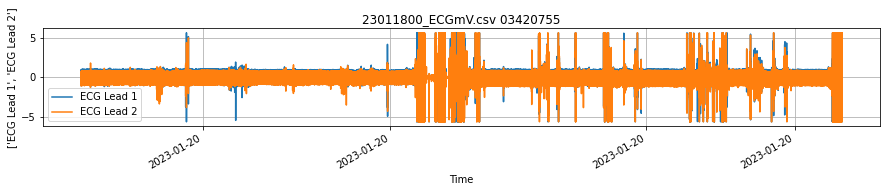

['23011802_ECGmV.csv', '03420415']


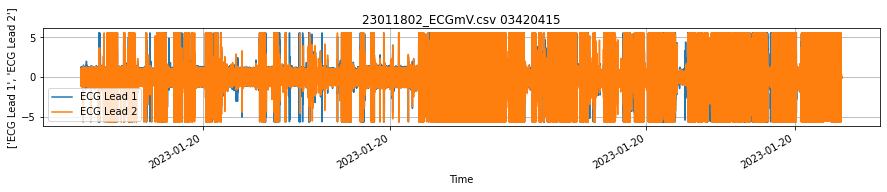

['23011802_ECGmV.csv', '03420427']


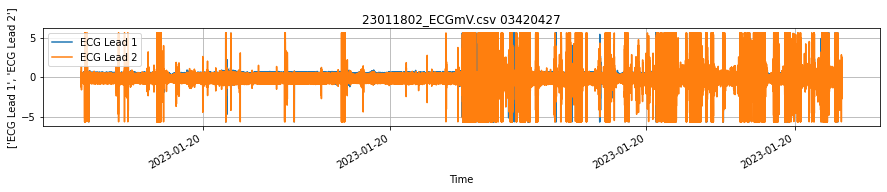

['23011800_ECGmV.csv', '03420426']


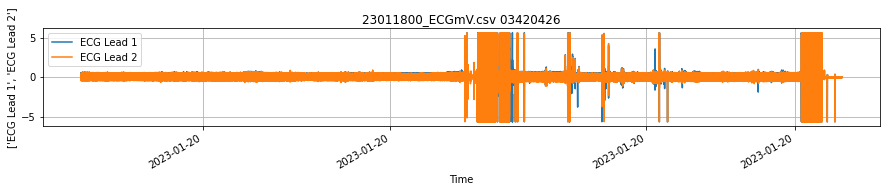

['23011802_ECGmV.csv', '03420456']


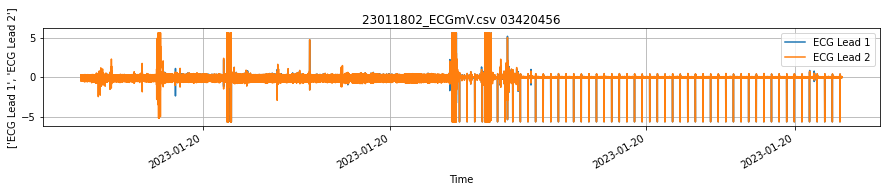

In [212]:
# plot the all the subfiles on the same region of time

for i,row in sub_files.iterrows():
    f = row['FileName']
    df =pd.read_csv(row['FullLoc'],header=0)
    s = row['Signal']
    print ([f,row['ID']])
    sig_df = eq_file_exct(row['FullLoc'])
#         sig_num = sig_df.select_dtypes(include=['int64','float64'])
    sig_num = sig_df[signal_interest].astype(float)
    a = sig_num.loc[trial_times[0]:trial_times[1]]
    a.plot(figsize=(15,2))
    d =a.std()
    plt.ylabel(signal_interest)
    plt.xticks(trial_ends)
    plt.grid()
    #plt.ylim([a[c].quantile(0.05)-d/2,a[c].quantile(0.95)+d/2])
    plt.title(f + ' ' + row['ID'])
    plt.show()

In [211]:
# select subset of files based on the type of output file 
datafile_type = 'NewSummary'
signal_interest = ['ECG Lead 1', 'ECG Lead 2']
sub_files=df_files.loc[df_files['Signal'] == datafile_type,:]
sub_files

['23011800_Indications.csv', '03420755']


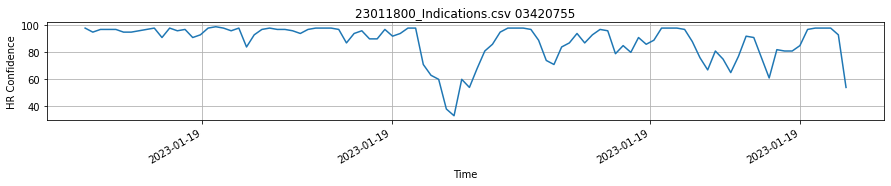

['23011802_Indications.csv', '03420415']


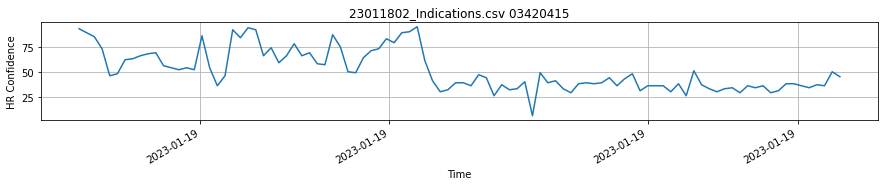

['23011802_Indications.csv', '03420427']


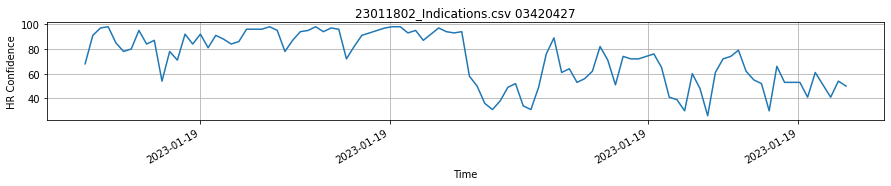

['23011800_Indications.csv', '03420426']


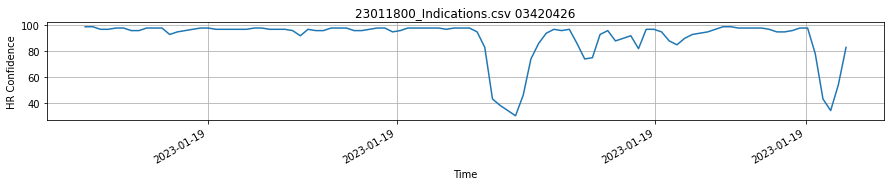

['23011802_Indications.csv', '03420456']


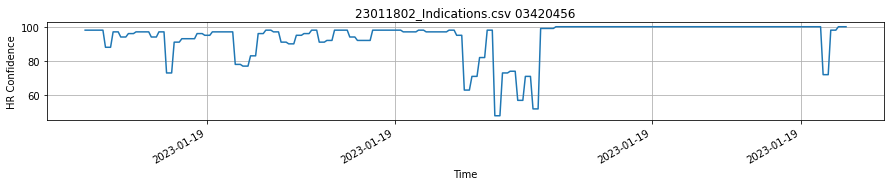

In [117]:
trial_times = pd.to_datetime(['2023-01-19 13:20:00.0','2023-01-19 13:45:00.0'])

for i,row in sub_files.iterrows():
    f = row['FileName']
    df =pd.read_csv(row['FullLoc'],header=0)
    s = row['Signal']
    print ([f,row['ID']])
    sig_df = eq_file_exct(row['FullLoc'])
#         sig_num = sig_df.select_dtypes(include=['int64','float64'])
    sig_num = sig_df[signal_interest].astype(float)
    a = sig_num.loc[trial_times[0]:trial_times[1]]
    a.plot(figsize=(15,2))
    d =a.std()
    plt.ylabel(signal_interest)
    plt.xticks(trial_ends)
    plt.grid()
    #plt.ylim([a[c].quantile(0.05)-d/2,a[c].quantile(0.95)+d/2])
    plt.title(f + ' ' + row['ID'])
    plt.show()

In [123]:
jerk= np.sqrt(np.square(sig_num.diff()).sum(axis=1))
jerk

Time
2023-01-19 13:06:26.003       0.000000
2023-01-19 13:06:26.042       0.000000
2023-01-19 13:06:26.082       0.000000
2023-01-19 13:06:26.121       0.000000
2023-01-19 13:06:26.160       0.000000
                              ...     
2023-01-19 13:51:27.097     709.735711
2023-01-19 13:51:27.136     324.263365
2023-01-19 13:51:27.175     279.632992
2023-01-19 13:51:27.214    1026.833784
2023-01-19 13:51:27.253    1094.177650
Length: 69153, dtype: float64

['23011800_AccMG.csv', '03420755']
['23011802_AccMG.csv', '03420415']
['23011802_AccMG.csv', '03420427']
['23011800_AccMG.csv', '03420426']
['23011802_AccMG.csv', '03420456']


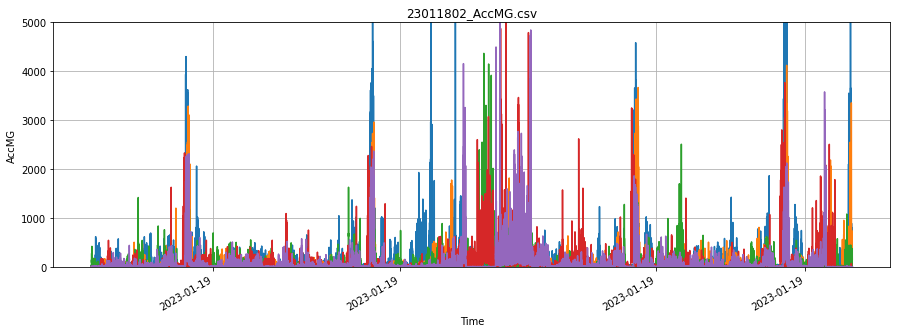

In [128]:
trial_times = pd.to_datetime(['2023-01-19 13:20:00.0','2023-01-19 13:45:00.0'])
datafile_type = 'AccMG'
signal_interest = ['Lateral Acc','Longitudinal Acc','Vertical Acc']
sub_files=df_files.loc[df_files['Signal'] == datafile_type,:]


fig = plt.figure(figsize=(15,5))

for i,row in sub_files.iterrows():
    f = row['FileName']
    df =pd.read_csv(row['FullLoc'],header=0)
    s = row['Signal']
    print ([f,row['ID']])
    sig_df = eq_file_exct(row['FullLoc'])
    if s.startswith('Acc'):
        sig_num = sig_df.loc[:,['X', 'Y', 'Z']].astype(float)
        # collapse acceleration into instentaneous jerk
        jerk= np.sqrt(np.square(sig_num.diff()).sum(axis=1))
        a = jerk.loc[trial_times[0]:trial_times[1]]
    else:
        sig_num = sig_df[signal_interest].astype(float)
        a = sig_num.loc[trial_times[0]:trial_times[1]]   
    a.plot(label=row['ID'][-3:])
    #d =a.std()
plt.ylabel(s)
plt.xticks(trial_ends)
plt.grid()
plt.ylim([0,5000])
#plt.ylim([a[c].quantile(0.05)-d/2,a[c].quantile(0.95)+d/2])
plt.title(f)
plt.show()

In [167]:
# trial_times = pd.to_datetime(['2023-01-19 13:20:00.0','2023-01-19 13:30:00.0'])
trials = [pd.to_datetime(['13:22:05.0','13:23:50.0']),pd.to_datetime(['13:28:10.20','13:29:55.20']), 
          pd.to_datetime(['13:36:47.80','13:38:32.80']),pd.to_datetime(['13:41:45.20','13:43:30.20'])]



['23011800_Belt.csv', '03420755']
['23011802_Belt.csv', '03420415']
['23011802_Belt.csv', '03420427']
['23011800_Belt.csv', '03420426']
['23011802_Belt.csv', '03420456']


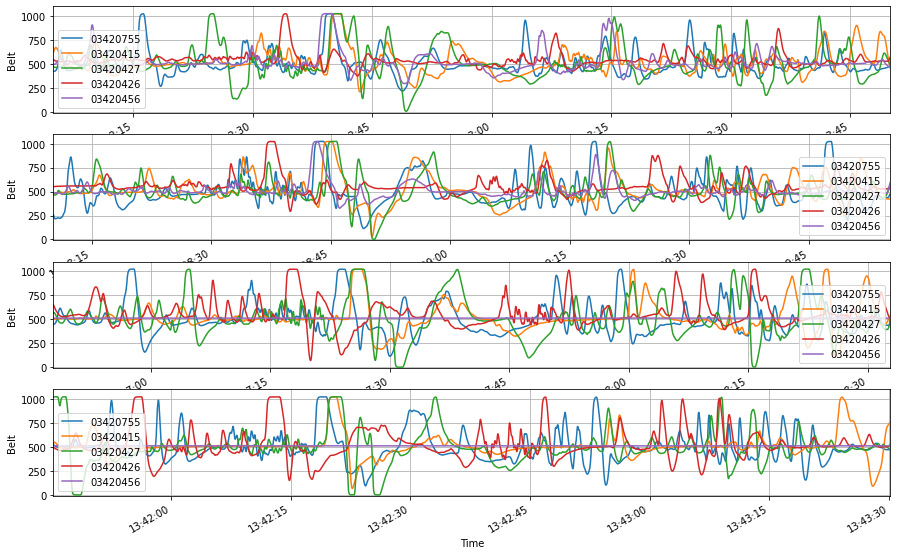

In [164]:
datafile_type = 'Belt'
signal_interest = ['Breathing']
yrange = [-10,1100]
sub_files=df_files.loc[df_files['Signal'] == datafile_type,:]

fig,axs = plt.subplots(4, 1, figsize=(15,10))

for i,row in sub_files.iterrows():
    f = row['FileName']
    s = row['Signal']
    print ([f,row['ID']])
    sig_df = eq_file_exct(row['FullLoc'])
    if s.startswith('Acc'):
        sig_df = eq_file_exct(row['FullLoc']).loc[:,['X', 'Y', 'Z']].astype(float)
        # collapse acceleration into instentaneous jerk
        sig_num= np.sqrt(np.square(sig_df.diff()).sum(axis=1))
        sig_num.rename({0:row['ID']},axis=1,inplace = True)
    else:
        sig_num = sig_df[signal_interest].astype(float)
        sig_num.rename({signal_interest[0]:row['ID']},axis=1,inplace = True)
    sig_num
    for i in range(len(trials)):
        trial_times = trials[i]
        a = sig_num.loc[trial_times[0]:trial_times[1]]   
        a.plot(label=row['ID'][-3:],ax=axs[i])
for i in range(len(trials)):
    axs[i].set_ylabel(s)
    trial_times = trials[i]
#     axs[i].set_xticks(trial_ends)
    axs[i].grid()
    axs[i].set_ylim(yrange)
    axs[i].set_xlim(trial_times)

plt.savefig('./plots/trials_' + s + '.png',dpi = 300)
plt.show()

['23011800_AccMG.csv', '03420755']
['23011802_AccMG.csv', '03420415']
['23011802_AccMG.csv', '03420427']
['23011800_AccMG.csv', '03420426']
['23011802_AccMG.csv', '03420456']


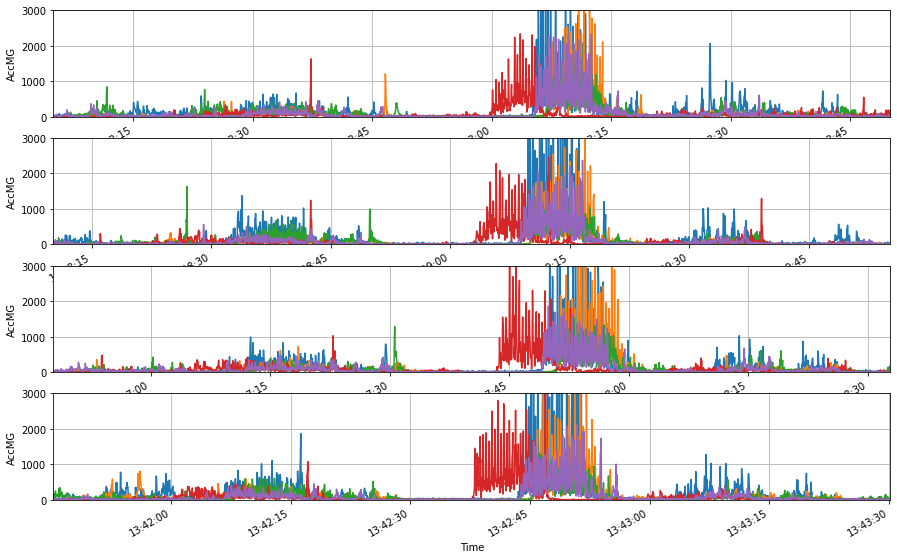

In [169]:
datafile_type = 'AccMG'
signal_interest = ['Lateral Acc','Longitudinal Acc','Vertical Acc']
yrange = [0,3000]
sub_files=df_files.loc[df_files['Signal'] == datafile_type,:]

fig,axs = plt.subplots(4, 1, figsize=(15,10))

for i,row in sub_files.iterrows():
    f = row['FileName']
    s = row['Signal']
    print ([f,row['ID']])
    sig_df = eq_file_exct(row['FullLoc'])
    if s.startswith('Acc'):
        sig_df = eq_file_exct(row['FullLoc']).loc[:,['X', 'Y', 'Z']].astype(float)
        # collapse acceleration into instentaneous jerk
        sig_num= np.sqrt(np.square(sig_df.diff()).sum(axis=1))
        sig_num.rename({0:row['ID']},axis=1,inplace = True)
    else:
        sig_num = sig_df[signal_interest].astype(float)
        sig_num.rename({signal_interest[0]:row['ID']},axis=1,inplace = True)
    sig_num
    for i in range(len(trials)):
        trial_times = trials[i]
        a = sig_num.loc[trial_times[0]:trial_times[1]]   
        a.plot(label=row['ID'][-3:],ax=axs[i])
for i in range(len(trials)):
    axs[i].set_ylabel(s)
    trial_times = trials[i]
#     axs[i].set_xticks(trial_ends)
    axs[i].grid()
    axs[i].set_ylim(yrange)
    axs[i].set_xlim(trial_times)

plt.savefig('./plots/trials_' + s + '.png',dpi = 300)
plt.show()

['23011800_Indications.csv', '03420755']
['23011802_Indications.csv', '03420415']
['23011802_Indications.csv', '03420427']
['23011800_Indications.csv', '03420426']
['23011802_Indications.csv', '03420456']


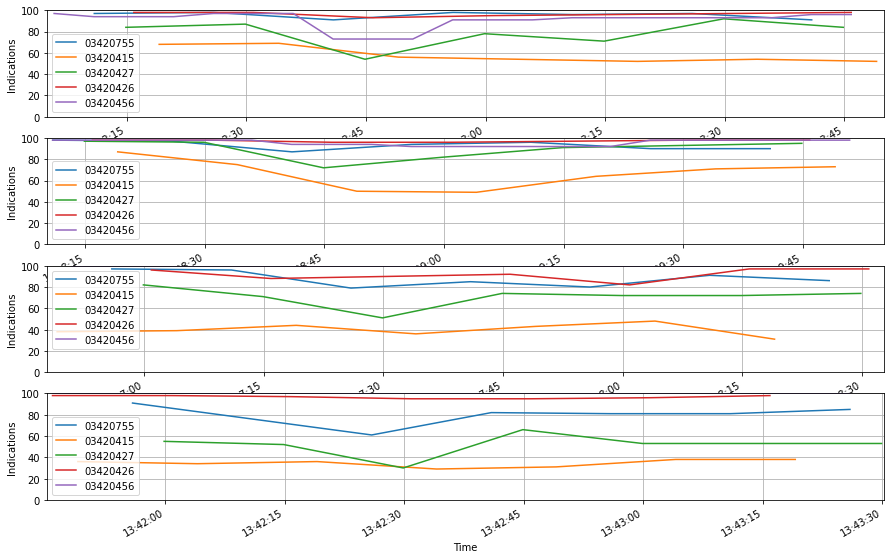

In [168]:
datafile_type = 'Indications'
signal_interest = ['HR Confidence']
yrange = [0,100]
sub_files=df_files.loc[df_files['Signal'] == datafile_type,:]

fig,axs = plt.subplots(4, 1, figsize=(15,10))

for i,row in sub_files.iterrows():
    f = row['FileName']
    s = row['Signal']
    print ([f,row['ID']])
    sig_df = eq_file_exct(row['FullLoc'])
    if s.startswith('Acc'):
        sig_df = eq_file_exct(row['FullLoc']).loc[:,['X', 'Y', 'Z']].astype(float)
        # collapse acceleration into instentaneous jerk
        sig_num= np.sqrt(np.square(sig_df.diff()).sum(axis=1))
        sig_num.rename({0:row['ID']},axis=1,inplace = True)
    else:
        sig_num = sig_df[signal_interest].astype(float)
        sig_num.rename({signal_interest[0]:row['ID']},axis=1,inplace = True)
    sig_num
    for i in range(len(trials)):
        trial_times = trials[i]
        a = sig_num.loc[trial_times[0]:trial_times[1]]   
        a.plot(label=row['ID'][-3:],ax=axs[i])
for i in range(len(trials)):
    axs[i].set_ylabel(s)
    trial_times = trials[i]
#     axs[i].set_xticks(trial_ends)
    axs[i].grid()
    axs[i].set_ylim(yrange)
    axs[i].set_xlim(trial_times)

plt.savefig('./plots/trials_' + s + '.png',dpi = 300)
plt.show()

['23011800_ECGmV.csv', '03420755']
['23011802_ECGmV.csv', '03420415']
['23011802_ECGmV.csv', '03420427']
['23011800_ECGmV.csv', '03420426']
['23011802_ECGmV.csv', '03420456']


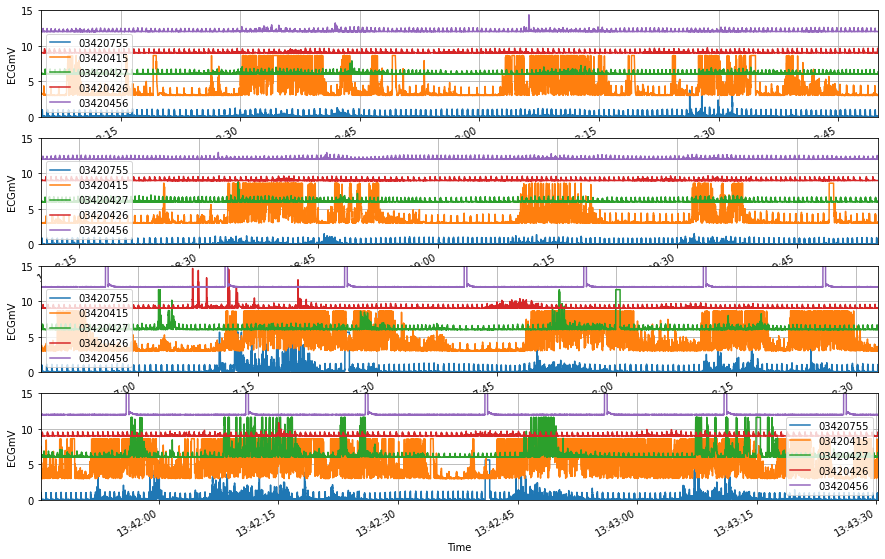

In [181]:
datafile_type = 'ECGmV'
signal_interest = ['ECG Lead 1'] # , 'ECG Lead 2'

# yrange = [-2,2]
yrange = [0,15]
sub_files=df_files.loc[df_files['Signal'] == datafile_type,:]

fig,axs = plt.subplots(4, 1, figsize=(15,10))
k = 0
for c,row in sub_files.iterrows():
    f = row['FileName']
    s = row['Signal']
    print ([f,row['ID']])
    sig_df = eq_file_exct(row['FullLoc'])
    if s.startswith('Acc'):
        sig_df = eq_file_exct(row['FullLoc']).loc[:,['X', 'Y', 'Z']].astype(float)
        # collapse acceleration into instentaneous jerk
        sig_num= np.sqrt(np.square(sig_df.diff()).sum(axis=1))
        sig_num.rename({0:row['ID']},axis=1,inplace = True)
    else:
        sig_num = sig_df[signal_interest].astype(float)
        sig_num.rename({signal_interest[0]:row['ID']},axis=1,inplace = True)
    sig_num
    for i in range(len(trials)):
        trial_times = trials[i]
        a = sig_num.loc[trial_times[0]:trial_times[1]].abs() + 3*k   
        a.plot(label=row['ID'][-3:],ax=axs[i])
    k+=1
    
for i in range(len(trials)):
    axs[i].set_ylabel(s)
    trial_times = trials[i]
#     axs[i].set_xticks(trial_ends)
    axs[i].grid()
    axs[i].set_ylim(yrange)
    axs[i].set_xlim(trial_times)

plt.savefig('./plots/trials_' + s + '.png',dpi = 300)
plt.show()

{'Signal': 'AccMG', 'Participant': 'Finn', 'DevID': 'NA', 'Date': 230117, 'Session': 2, 'FileName': '23011702_AccMG.csv', 'FullLoc': './Fit_tests/Finn1/23011702_AccMG.csv'}


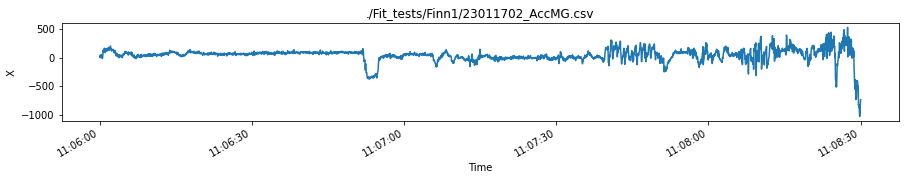

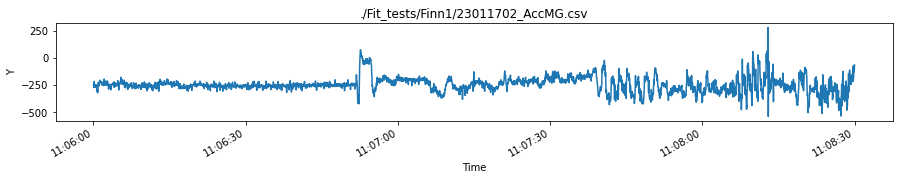

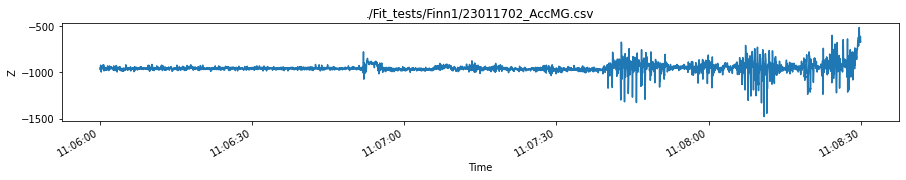

{'Signal': 'RR', 'Participant': 'Finn', 'DevID': 'NA', 'Date': 230117, 'Session': 2, 'FileName': '23011702_RR.csv', 'FullLoc': './Fit_tests/Finn1/23011702_RR.csv'}


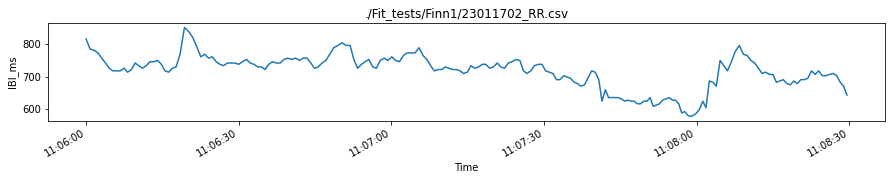

{'Signal': 'Belt', 'Participant': 'Finn', 'DevID': 'NA', 'Date': 230117, 'Session': 2, 'FileName': '23011702_Belt.csv', 'FullLoc': './Fit_tests/Finn1/23011702_Belt.csv'}


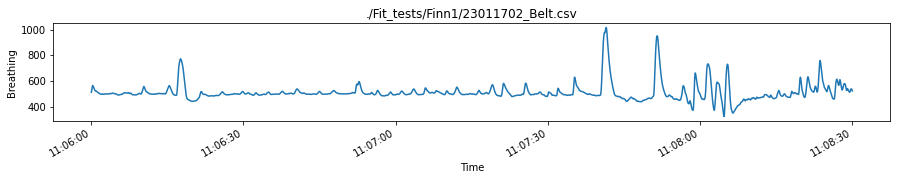

{'Signal': 'ECGmV', 'Participant': 'Finn', 'DevID': 'NA', 'Date': 230117, 'Session': 2, 'FileName': '23011702_ECGmV.csv', 'FullLoc': './Fit_tests/Finn1/23011702_ECGmV.csv'}


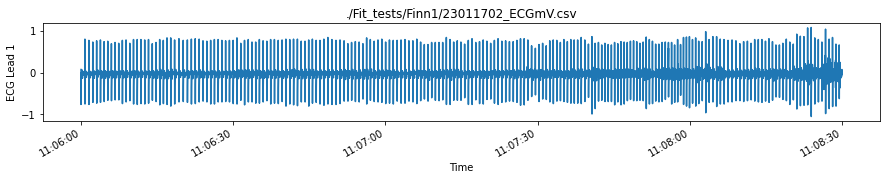

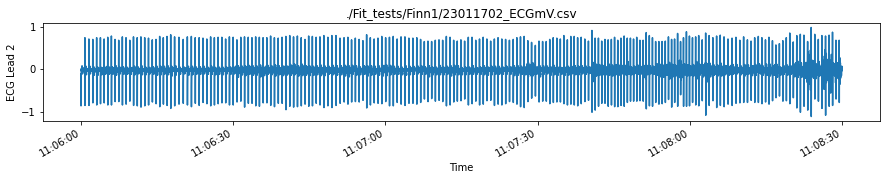

In [60]:
t1 = pd.to_datetime('2023-01-17 11:06:00.0').time()
t2 = pd.to_datetime('2023-01-17 11:08:30.0').time()

for f in C.loc[:,'FullLoc']:
    sig_df = eq_file_exct(f)
    a = sig_df.between_time(t1,t2).select_dtypes(include=['int64','float64'])
    for c in a.columns:
        a[c].plot(figsize=(15,2))
        plt.ylabel(c)
        plt.title(f)
        plt.show()

{'Signal': 'AccMG', 'Participant': 'Finn', 'DevID': 'NA', 'Date': 230117, 'Session': 2, 'FileName': '23011702_AccMG.csv', 'FullLoc': './Fit_tests/Finn1/23011702_AccMG.csv'}


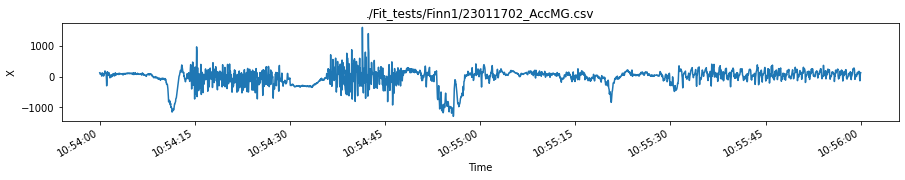

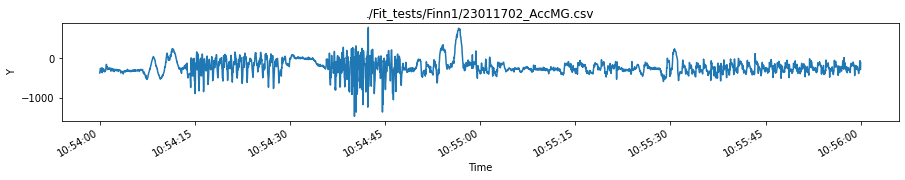

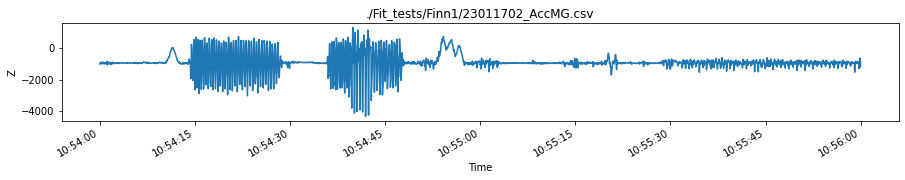

{'Signal': 'RR', 'Participant': 'Finn', 'DevID': 'NA', 'Date': 230117, 'Session': 2, 'FileName': '23011702_RR.csv', 'FullLoc': './Fit_tests/Finn1/23011702_RR.csv'}


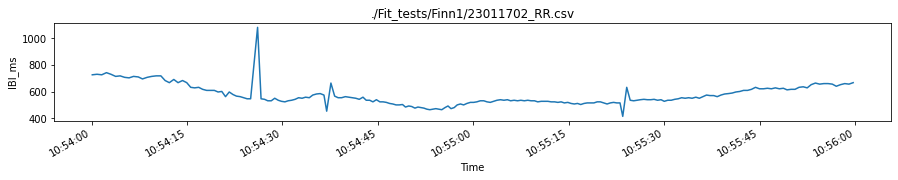

{'Signal': 'Belt', 'Participant': 'Finn', 'DevID': 'NA', 'Date': 230117, 'Session': 2, 'FileName': '23011702_Belt.csv', 'FullLoc': './Fit_tests/Finn1/23011702_Belt.csv'}


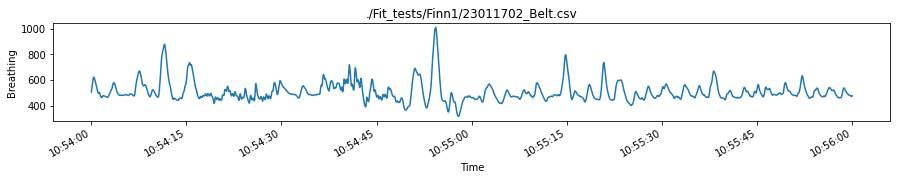

{'Signal': 'ECGmV', 'Participant': 'Finn', 'DevID': 'NA', 'Date': 230117, 'Session': 2, 'FileName': '23011702_ECGmV.csv', 'FullLoc': './Fit_tests/Finn1/23011702_ECGmV.csv'}


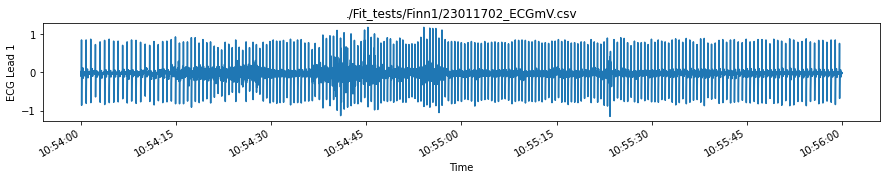

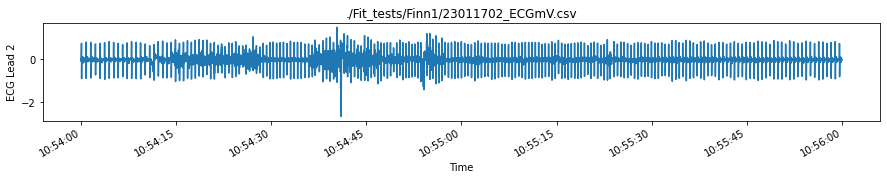

In [63]:
t1 = pd.to_datetime('2023-01-17 10:54:00.0').time()
t2 = pd.to_datetime('2023-01-17 10:56:00.0').time()

for f in C.loc[:,'FullLoc']:
    sig_df = eq_file_exct(f)
    a = sig_df.between_time(t1,t2).select_dtypes(include=['int64','float64'])
    for c in a.columns:
        a[c].plot(figsize=(15,2))
        plt.ylabel(c)
        plt.title(f)
        plt.show()